In [3]:
import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("../data/01_raw/data/TVC_logger_3_betula.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('Record')
df

,DateTime,Tsoil.C.hummock,Tair.C,RH.percent,VWC.m3.per.m3.interhummock,VWC.m3.per.m3.hummock
Record,,,,,,
1,2013-08-02 23:40:00,11.0269,15.7624,79.46,0.26180,0.13680
2,2013-08-02 23:50:00,10.9539,15.5471,80.05,0.26124,0.13736
3,2013-08-03 00:00:00,10.8977,15.0431,80.83,0.26156,0.13704
4,2013-08-03 00:10:00,10.8319,14.2438,82.57,0.26229,0.13736
5,2013-08-03 00:20:00,10.7582,13.8772,85.02,0.26201,0.13704
...,...,...,...,...,...,...
107819,2015-08-21 17:20:00,6.0770,15.3660,62.70,0.19350,0.13180
107820,2015-08-21 17:30:00,6.1790,14.0980,65.50,0.19350,0.13180
107821,2015-08-21 17:40:00,6.2550,16.3440,64.70,0.19350,0.13180


In [5]:
df.dtypes

DateTime                      datetime64[ns]
Tsoil.C.hummock                      float64
Tair.C                               float64
RH.percent                           float64
VWC.m3.per.m3.interhummock           float64
VWC.m3.per.m3.hummock                float64
dtype: object

In [6]:
df.drop(['DateTime'], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Tsoil.C.hummock,107823.0,-1.828507,6.454091,-14.19700,-7.8690,-0.39500,3.3800,13.8100
Tair.C,107823.0,-6.342978,15.725561,-42.69850,-19.8581,-4.25700,5.9652,31.8191
RH.percent,107823.0,85.617563,13.612570,20.39000,82.2600,88.90000,94.5000,100.0000
VWC.m3.per.m3.interhummock,107823.0,0.146827,0.088468,0.04900,0.0613,0.11290,0.2436,0.3053
VWC.m3.per.m3.hummock,107823.0,0.081777,0.053661,0.01501,0.0243,0.10144,0.1332,0.2124


Simulo la costruzione di indicatori che possano aumentare il dataset disponibile

def rolling_mean(df, col_name, window):
    return df[col_name].rolling(window).mean()

for col in df.columns:
    if df[col].dtype == 'float64':
        df[f'rollmean5_{col}'] = rolling_mean(df, col, 6)
        df[f'rollstd5_{col}'] = df[col].rolling(6).std()

In [7]:
df.dropna().drop(["DateTime"], axis=1)

,Tsoil.C.hummock,Tair.C,RH.percent,VWC.m3.per.m3.interhummock,VWC.m3.per.m3.hummock
Record,,,,,
1,11.0269,15.7624,79.46,0.26180,0.13680
2,10.9539,15.5471,80.05,0.26124,0.13736
3,10.8977,15.0431,80.83,0.26156,0.13704
4,10.8319,14.2438,82.57,0.26229,0.13736
5,10.7582,13.8772,85.02,0.26201,0.13704
...,...,...,...,...,...
107819,6.0770,15.3660,62.70,0.19350,0.13180
107820,6.1790,14.0980,65.50,0.19350,0.13180
107821,6.2550,16.3440,64.70,0.19350,0.13180


Costruisco un modello a caso

In [8]:
import tensorflow as tf

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM

In [10]:
class MyTFModel(Model):
    def __init__(self):
        super().__init__()
        self.lstm = LSTM(units=100)
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(10)
        self.dense3 = Dense(2)
    
    def call(self, x):
        x = self.lstm(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)
    
model = MyTFModel()

In [14]:
tf.keras.saving.serialize_keras_object(model)

{'module': None,
 'class_name': 'MyTFModel',
 'config': {},
 'registered_name': 'MyTFModel'}

In [9]:
df = df.dropna().drop(["DateTime"], axis=1)

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
num_features

5

In [12]:
# Normalise
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\paolo\AppData\Local\Temp\ipykernel_7536\3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


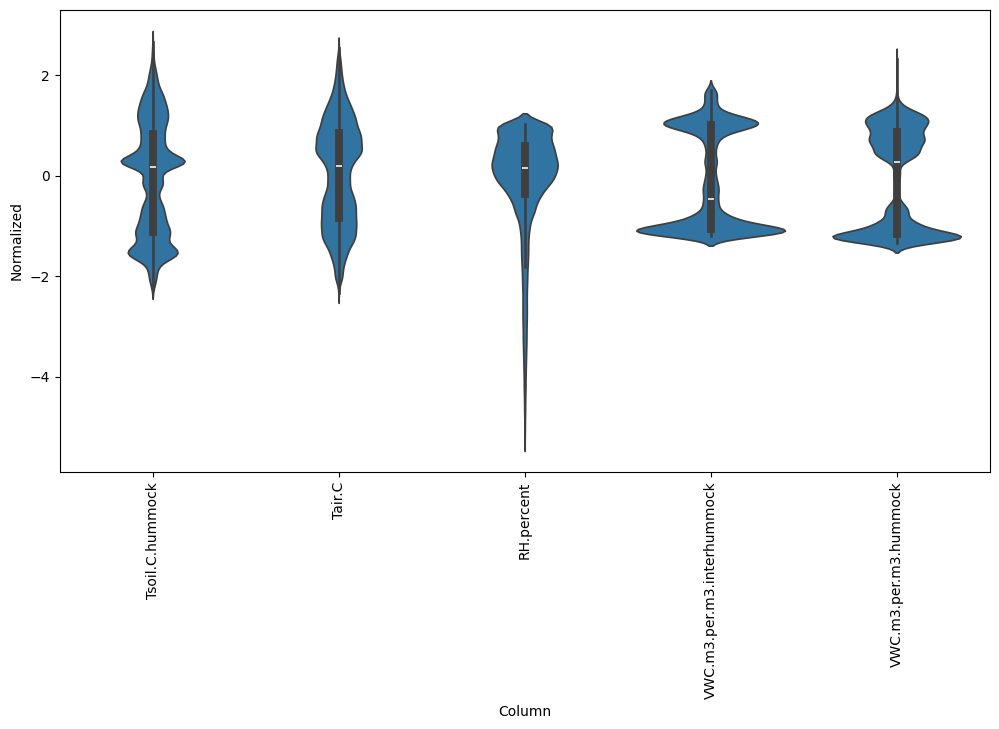

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [15]:
# WINDOWING
def get_windowed_data(df, window_size, label_cols):
    label_to_index = {name: i for i, name in enumerate(df.columns)}
    label_cols_indices = []
    if isinstance(label_cols, list):
        for col in label_cols:
            label_cols_indices.append(label_to_index[col])
    else:
        label_cols_indices.append(label_to_index[label_cols])
        
    X = []
    Y = []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i+window_size].values)
        Y.append(df.iloc[i+window_size, label_cols_indices].values)

    return np.array(X), np.array(Y)

X, Y = get_windowed_data(train_df, 10, ["RH.percent", "Tair.C"])

In [16]:
X.shape, Y.shape

((75466, 10, 5), (75466, 2))

In [17]:
X.shape, model(X).shape

((75466, 10, 5), TensorShape([75466, 2]))

### METRICHE

In [18]:
loss = tf.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
metrics = [tf.metrics.MeanAbsoluteError()]

In [19]:
model.compile(optimizer, loss, metrics=metrics)

In [20]:
X_val, Y_val = get_windowed_data(val_df, 10, ["RH.percent", "Tair.C"])
X_test, Y_test = get_windowed_data(test_df, 10, ["RH.percent", "Tair.C"]) 

In [21]:
history = model.fit(X, Y, validation_data=(X_val, Y_val), epochs=15)

Epoch 1/15

2359/2359 [==============================] - 23s 9ms/step - loss: 0.0066 - mean_absolute_error: 0.0403 - val_loss: 0.0022 - val_mean_absolute_error: 0.0330
Epoch 2/15
2359/2359 [==============================] - 22s 9ms/step - loss: 0.0014 - mean_absolute_error: 0.0248 - val_loss: 0.0020 - val_mean_absolute_error: 0.0321
Epoch 3/15
2359/2359 [==============================] - 19s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0221 - val_loss: 0.0016 - val_mean_absolute_error: 0.0274
Epoch 4/15
2359/2359 [==============================] - 18s 8ms/step - loss: 0.0011 - mean_absolute_error: 0.0210 - val_loss: 0.0019 - val_mean_absolute_error: 0.0307
Epoch 5/15
2359/2359 [==============================] - 19s 8ms/step - loss: 0.0010 - mean_absolute_error: 0.0203 - val_loss: 0.0015 - val_mean_absolute_error: 0.0237
Epoch 6/15
2359/2359 [==============================] - 19s 8ms/step - loss: 9.9187e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0022 - val_mean_absolute_error: 

In [22]:
model.evaluate(X_test, Y_test)

337/337 [==============================] - 2s 6ms/step - loss: 0.0044 - mean_absolute_error: 0.0383


[0.004436082672327757, 0.03826645761728287]

In [23]:
model.export("../data/06_models/tensorflow_lstm")

INFO:tensorflow:Assets written to: ../data/06_models/tensorflow_lstm\assets


INFO:tensorflow:Assets written to: ../data/06_models/tensorflow_lstm\assets


Saved artifact at '../data/06_models/tensorflow_lstm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1905726339024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905726340944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905726339792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905726339600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905726340560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905768306576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905768300816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905768302544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1905768300624: TensorSpec(shape=(), dtype=tf.resource, name=None)
